# Unsupervised clustering of profiles summarized to the species level

The metadata labels are wrong. Can we identify clusters using unsupervised techniques?

+ PCA
+ tSNE
+ UMAP
+ diffusion map

In [1]:
setwd("..")

In [3]:
library(readr)
library(dplyr)
library(purrr)
library(tidyr)
library(tibble)
library(ggplot2)
library(ggthemes)
library(Rtsne)
library(umap)
source("scripts/utils.R")

In [4]:
set.seed(1) 

In [5]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

## Read in gather results and sample metadata

In [6]:
# separate empty files from populated files
files <- Sys.glob("results/*gather.csv")
empty_files <- character()
populated_files <- character()
for(i in 1:length(files)){
    # check and see if the file is empty, e.g. has not gather matches
    file_size <- file.size(files[i])
    if(file_size == 0){
        empty_files = c(empty_files, files[i])
    } else {
        populated_files = c(populated_files, files[i])
    }
}

In [7]:
# read in populated files
# empty files are ignored
gather_results <- populated_files %>%
  map_dfr(read_gather)

In [10]:
# read in gtdb lineage info 
gtdb_lineages <- read_csv("https://osf.io/p6z3w/download", show_col_types = F)

In [12]:
# join lineage information with gather results
gather_results <- gather_results %>%
  mutate(accession = gsub(" .*", "", name)) %>%
  left_join(gtdb_lineages, by = c("accession" = "ident"))

In [13]:
head(gather_results)

intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,⋯,query_md5,query_bp,accession,superkingdom,phylum,class,order,family,genus,species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6500000,0.03421053,0.9558824,0.03421053,0.025043505,10.184615,8.0,5.891042,"GCF_003478165.1 Blautia sp. OF01-4LB strain=OF01-4LB, ASM347816v1",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,1fe666bd,190000000,GCF_003478165.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Blautia,s__Blautia sp001304935
4100000,0.02157895,0.8723404,0.02157895,0.022017099,14.195122,13.0,6.925455,"GCF_012271835.1 [Clostridium] innocuum strain=LC-LUMC-CI-001, ASM1227183v1",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,1fe666bd,190000000,GCF_012271835.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Erysipelotrichales,f__Erysipelotrichaceae,g__Clostridium_AQ,s__Clostridium_AQ innocuum
3900000,0.02052632,0.8666667,0.02052632,0.018423243,12.487179,9.0,10.027838,"GCF_003459645.1 Erysipelatoclostridium ramosum strain=AF19-21AC, ASM345964v1",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,1fe666bd,190000000,GCF_003459645.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Erysipelotrichales,f__Erysipelatoclostridiaceae,g__Erysipelatoclostridium,s__Erysipelatoclostridium ramosum
3900000,0.02052632,0.7358491,0.02052632,0.004804419,3.256410,3.0,2.059599,"GCF_001404335.1 Faecalicatena contorta strain=2789STDY5834876, 13470_2#95",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,1fe666bd,190000000,GCF_001404335.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Muricomes,s__Muricomes contortus_B
3000000,0.01578947,0.7894737,0.01578947,0.005598850,4.933333,4.0,3.295789,"GCF_001405515.1 Bacteroides caccae strain=2789STDY5834946, 14207_7#69",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,1fe666bd,190000000,GCF_001405515.1,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides caccae
3000000,0.01578947,0.8108108,0.01578947,0.011424680,10.066667,10.5,4.647102,"GCF_003434665.1 Sellimonas intestinalis strain=AM14-42, ASM343466v1",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,1fe666bd,190000000,GCF_003434665.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Sellimonas,s__Sellimonas intestinalis


## Format for clustering

In [14]:
gather_formatted_species <- gather_results %>%
  group_by(query_name, species) %>%
  summarize(species_f_unique_weighted = sum(f_unique_weighted))

`summarise()` has grouped output by 'query_name'. You can override using the `.groups` argument.



In [16]:
# samples (metagenomes) need to be rownames, species need to be columns
gather_formatted_species <- gather_formatted_species %>%
  select(query_name, species, species_f_unique_weighted) %>%
  distinct() %>% # somehow duplicates snuck in?
  pivot_wider(id_cols = c("query_name"), names_from = species, values_from = species_f_unique_weighted)

In [18]:
gather_formatted_species <- gather_formatted_species %>% 
  replace(is.na(.), 0)
# gather_formatted[is.na(gather_formatted)] <- 0 # replace NAs with 0s

In [20]:
gather_formatted_species[1:5, 1:5]
dim(gather_formatted_species)

query_name,s__Abiotrophia defectiva,s__Actinomyces graevenitzii,s__Actinomyces naeslundii,s__Actinomyces oris
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DRR014176,0.00003783007,0.00003783007,0.00003783007,0.00022698040
DRR019507,0.00000000000,0.00000000000,0.00000000000,0.00000000000
DRR021939,0.00000000000,0.00000000000,0.00000000000,0.00000000000
DRR025071,0.00000000000,0.00000000000,0.00000000000,0.00005771939
DRR033608,0.00000000000,0.00000000000,0.00000000000,0.00000000000


[1]  7999 39773

## PCA

In [21]:
gather_pca <- gather_formatted_species %>%
  column_to_rownames("query_name") %>%
  prcomp()

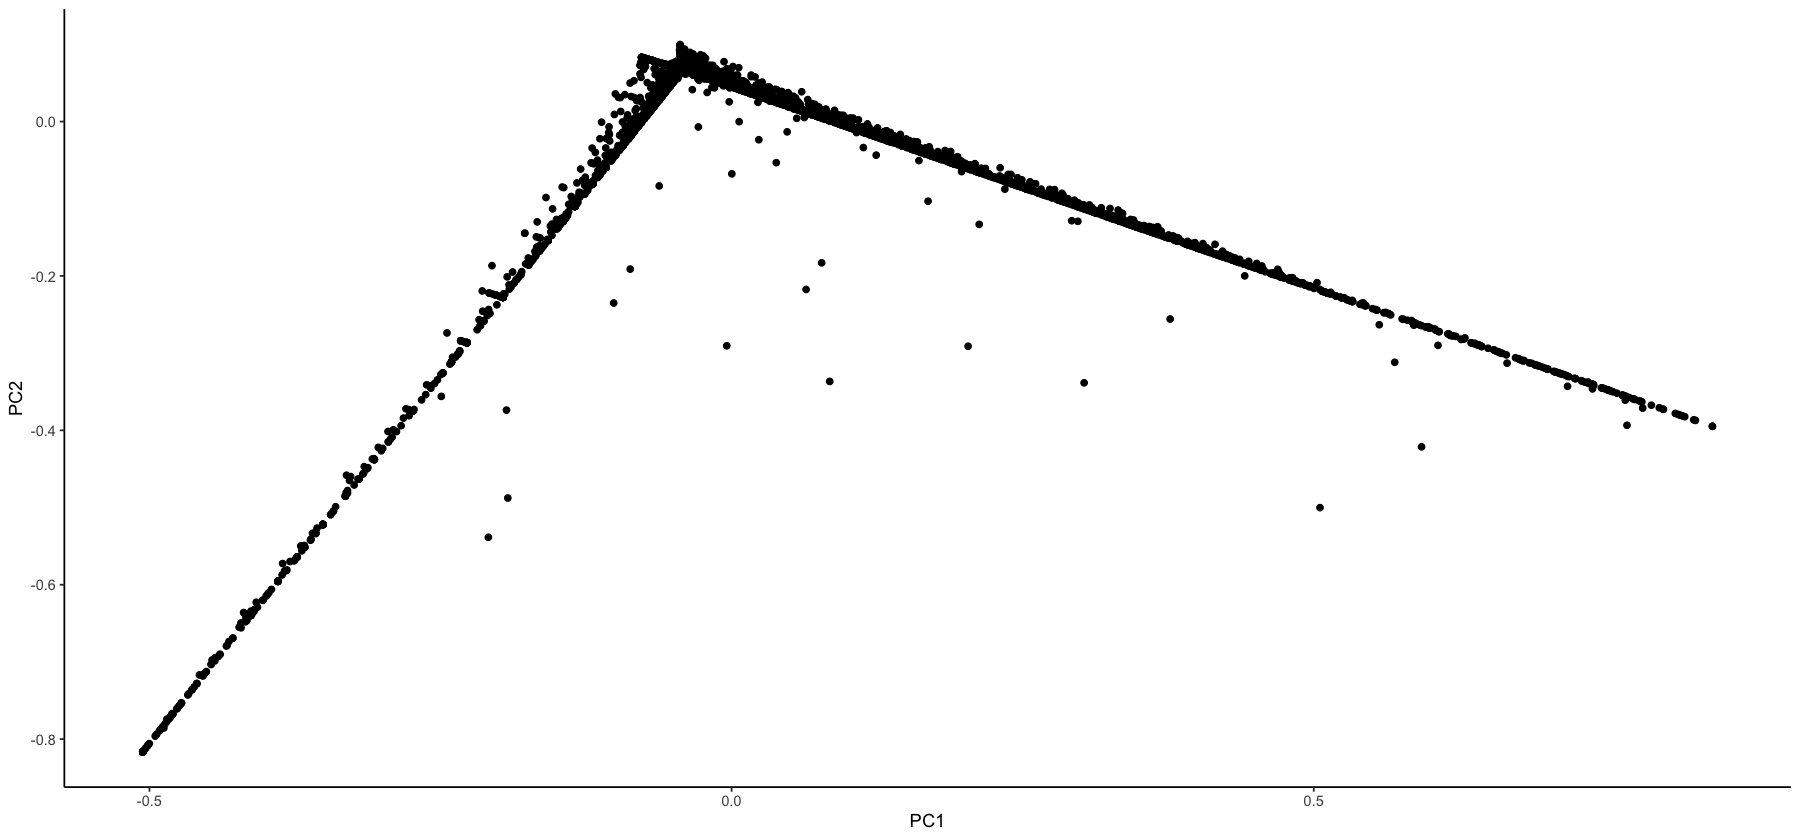

In [22]:
ggplot(as.data.frame(gather_pca$x), aes(x = PC1, y = PC2)) +
  geom_point() +
  theme_classic()

## tSNE

https://datavizpyr.com/how-to-make-tsne-plot-in-r/

In [24]:
# read in metadata
runinfo <- read_csv("all.runinfo.csv", show_col_types = F)
ebi <- read_csv("ebi_mgnify_samples.csv", show_col_types = F)

Warning message:
“One or more parsing issues, see `problems()` for details”


In [26]:
biome_fill <- gather_umap_results %>%
  group_by(biome) %>% 
  tally() %>%
  arrange(desc(n)) %>%
  select(biome, num_biome = n)

In [39]:
gather_tsne <- gather_formatted_species %>%
  column_to_rownames("query_name") %>%
  distinct() %>%
  scale() %>% 
  Rtsne()

In [44]:
tsne_df <- gather_tsne$Y %>% 
  as.data.frame() %>%
  rename(tSNE1="V1",
         tSNE2="V2") 

In [50]:
tmp <- gather_formatted_species %>%
  column_to_rownames("query_name") %>%
  distinct()

tsne_df <- tsne_df %>%
  mutate(Run = rownames(tmp)) %>%
  left_join(runinfo, by = "Run") %>%
  left_join(ebi, by = c("Sample" = "accession"))


In [51]:
tsne_df <- left_join(tsne_df, biome_fill, by = "biome") %>%
  mutate(biome_fill = ifelse(num_biome > 10, biome, "other"))

Warning message:
“Removed 6340 rows containing missing values (geom_point).”


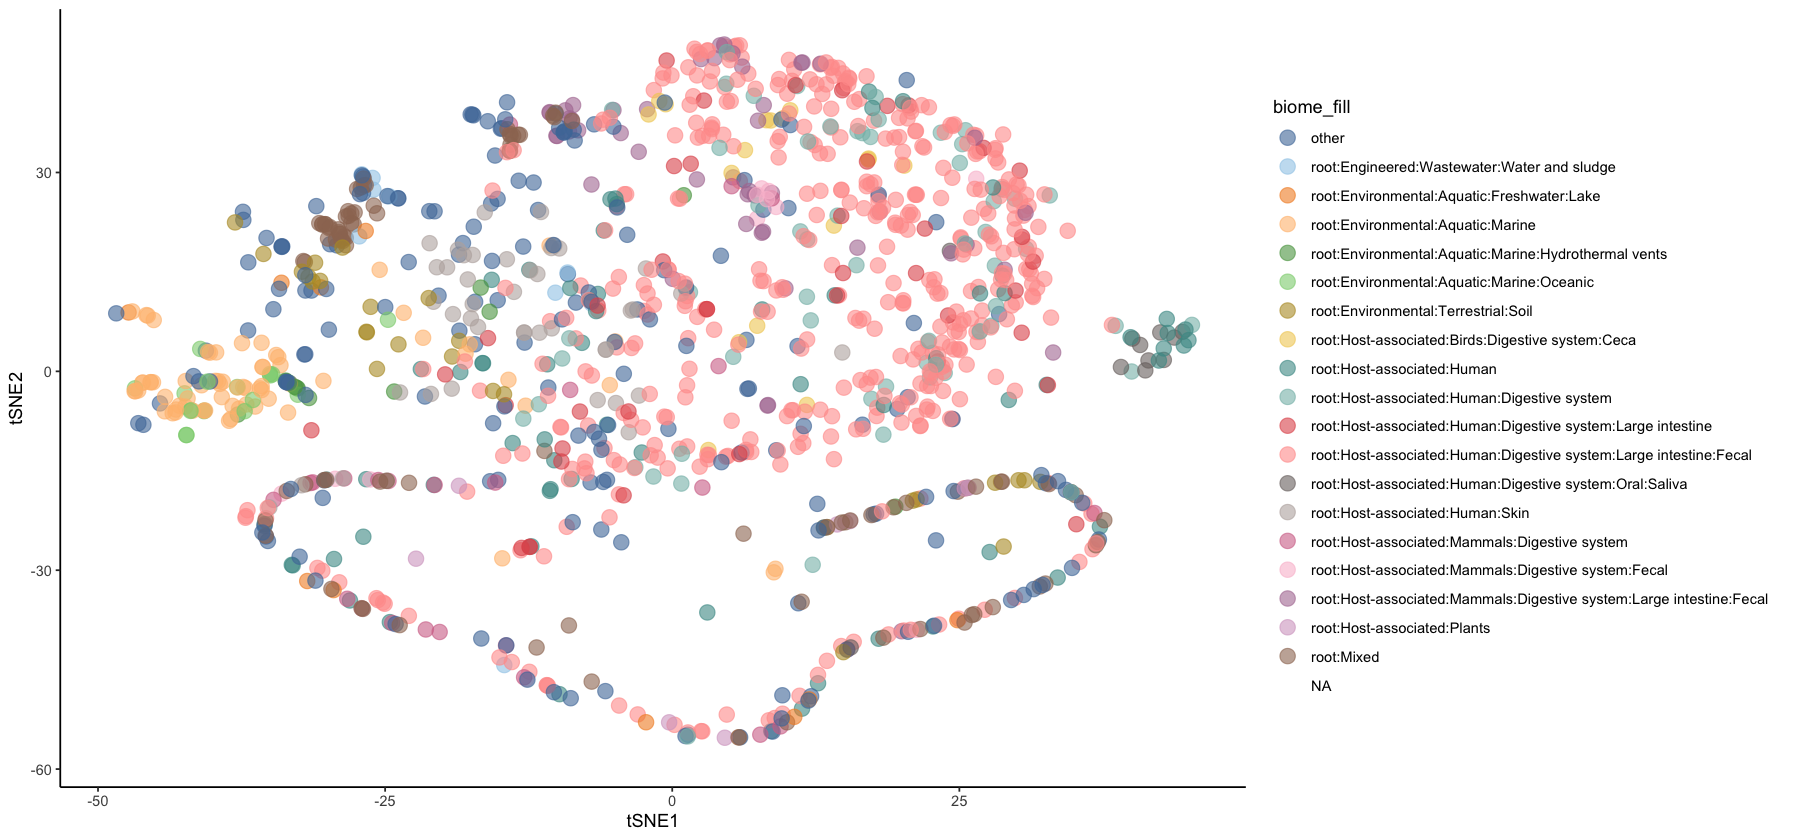

In [55]:
ggplot(tsne_df, aes(x = tSNE1, y = tSNE2, color = biome_fill))+
  geom_point(size = 4, alpha = .6)+
  theme(legend.position="bottom") +
  theme_classic() +
  scale_color_tableau(palette = "Tableau 20")

## UMAP

In [23]:
gather_umap <- gather_formatted_species %>%
  column_to_rownames("query_name") %>%
  scale() %>% 
  umap()

In [25]:
gather_umap_results <- as.data.frame(gather_umap$layout) %>%
  rownames_to_column("Run") %>%
  left_join(runinfo, by = "Run") %>%
  left_join(ebi, by = c("Sample" = "accession"))

In [27]:
gather_umap_results <- left_join(gather_umap_results, biome_fill, by = "biome") %>%
  mutate(biome_fill = ifelse(num_biome > 10, biome, "other"))

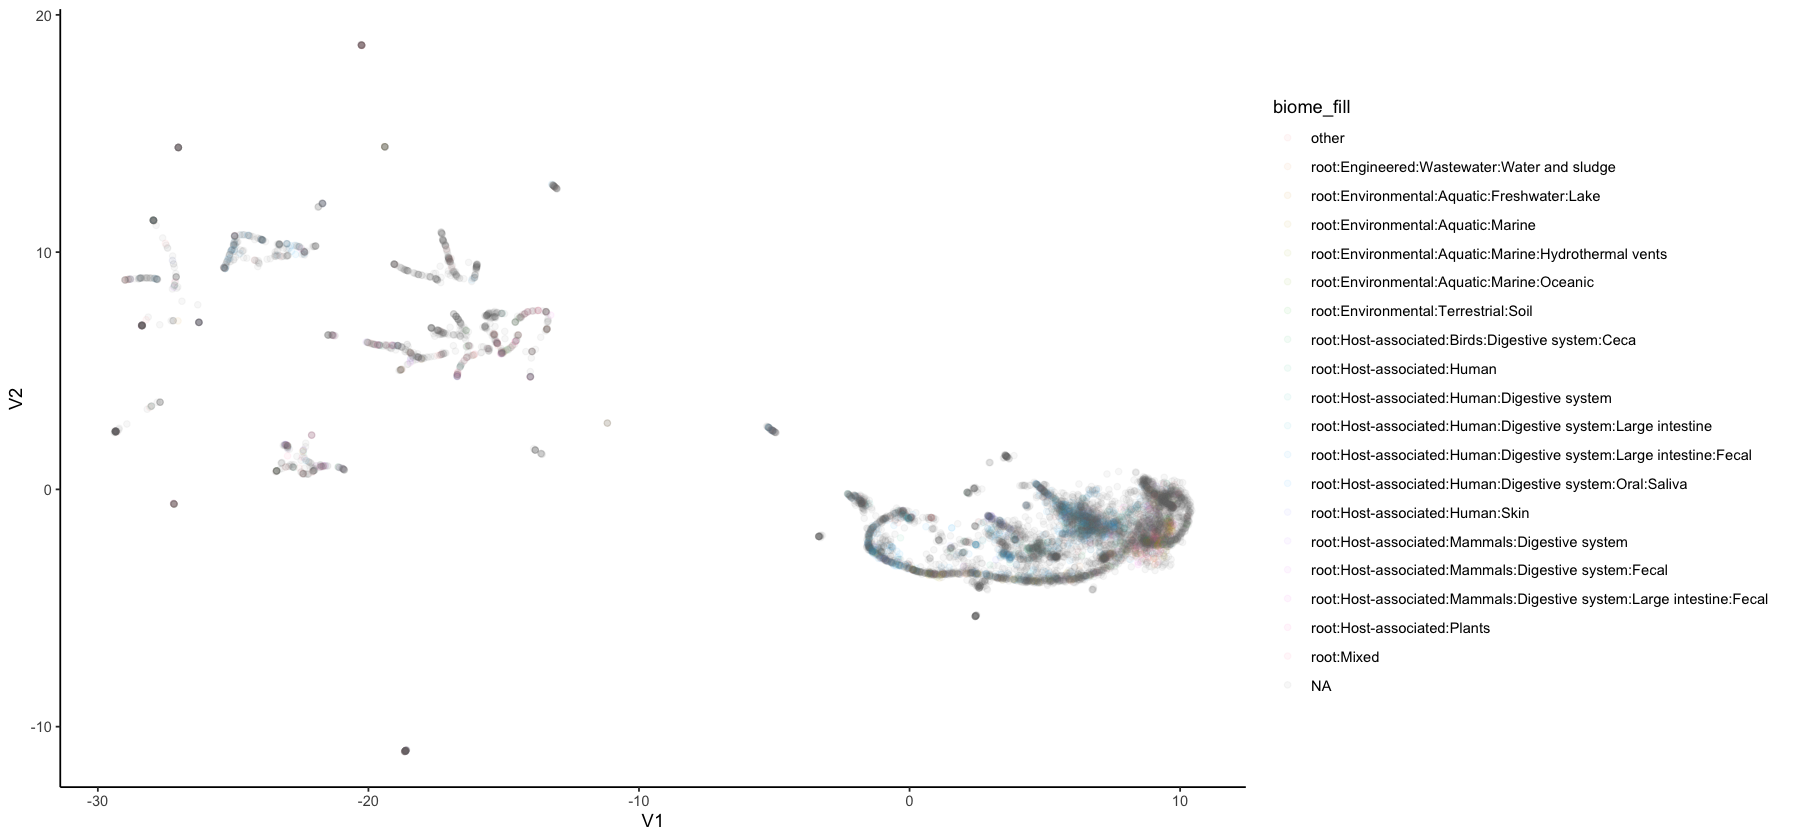

In [28]:
ggplot(gather_umap_results, aes(x = V1, y = V2, color = biome_fill)) +
  geom_point(alpha = .05) +
  theme_classic() +
  scale_fill_tableau(palette = "Tableau 20")

In [29]:
gather_umap_noscale <- gather_formatted_species %>%
  column_to_rownames("query_name") %>% 
  umap()

In [30]:
gather_umap_noscale_results <- as.data.frame(gather_umap_noscale$layout) %>%
  rownames_to_column("Run") %>%
  left_join(runinfo, by = "Run") %>%
  left_join(ebi, by = c("Sample" = "accession"))

gather_umap_noscale_results <- left_join(gather_umap_noscale_results, biome_fill, by = "biome") %>%
  mutate(biome_fill = ifelse(num_biome > 10, biome, "other"))

Warning message:
“Removed 6769 rows containing missing values (geom_point).”


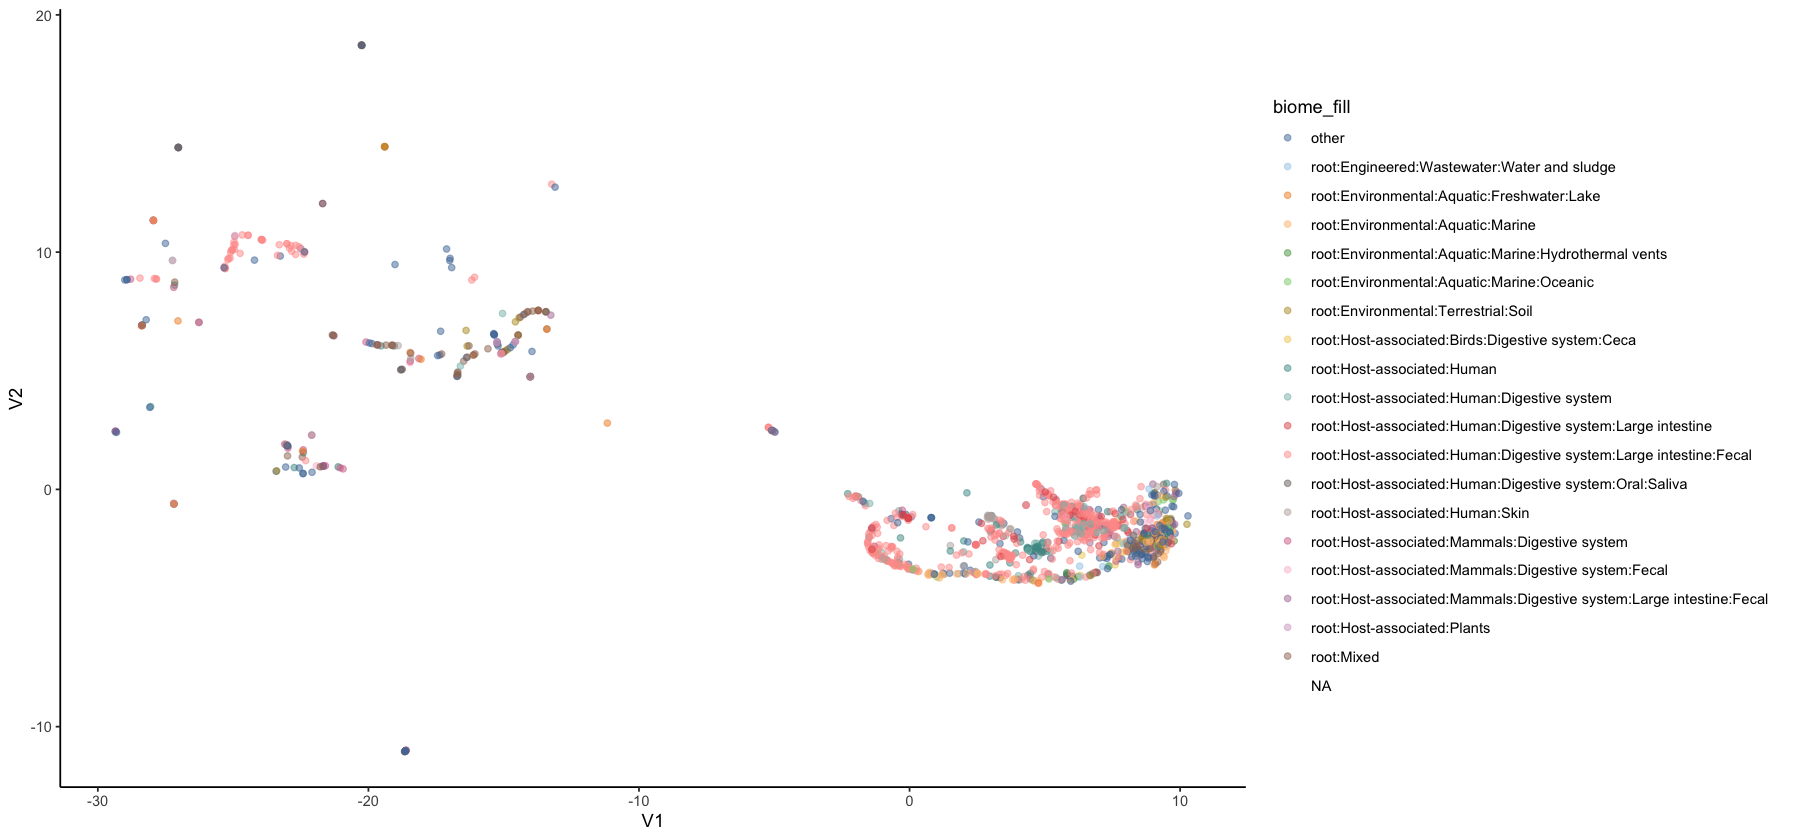

In [34]:
ggplot(gather_umap_results, aes(x = V1, y = V2, color = biome_fill)) +
  geom_point(alpha = .5) +
  theme_classic() +
  scale_color_tableau(palette = "Tableau 20")

## Diffusion map

In [35]:
## as implemented here: https://doi.org/10.6084/m9.figshare.12864011.v4
## standardize columns func
norm_mat <- function(mat){
  ms <- apply(mat, 2, function(col) (col - mean(col)) / sd(col))
  ms
}
## compute euclid dist and standrdize to similarities
get_euc <- function(mat, n.threads = 1, alt = 'euclidean'){
  if(n.threads > 1){
    eu <- parDist(mat, method = alt, threads = n.threads) %>% as.matrix()
    ieu <- 1 / eu
    diag(ieu) <- 0
  }
  
  if(n.threads == 1){
    eu <- dist(mat, method = alt) %>% as.matrix()
    ieu <- 1 / eu
    diag(ieu) <- 0
  }
  ieu
}
## function to threshold the normalized distance mat
threshold <- function(mat, top_k = 10){
  thr <- mat
  tnr <- nrow(thr)
  ## set similarities outside of the top k to 0
  for(i in 1:tnr){
    ## rank entries in each row in reverse order (so largest value == rank 1), 
    ## and set entries that are outside of 1:k to 0
    thr[i, !rank(-thr[i, ], ties.method = 'random') %in% 1:top_k] <- 0
  }
  
  for(i in 1:tnr){
    for(j in 1:tnr){
      if(thr[i, j] == 0 & thr[j, i] != 0){
        thr[i, j] <- thr[j, i]
      }
    }
  }
  thr
}
## function to calculate norm laplacian
get_laplac <- function(mat){
  L <- -mat
  S <- rowSums(mat)
  nL <- L / S
  diag(nL) <- 1
  nL
}

In [36]:
## build diffusion map
nm <- gather_formatted_species %>%
  column_to_rownames("query_name") %>% 
  norm_mat()                    # normalize

aff <- nm %>%
  get_euc(., n.threads = 1) %>% 
  threshold(., top_k = 10)      # make affinity matrix

Lij <- aff %>% get_laplac()     # compute laplacian

eig <- eigen(Lij)               # smallest keig vectors

evl <- eig$values %>%           # get eigenvalues
  Re() %>%
  round(., digits = 10)

evc <- eig$vectors %>%          # get eigenvectors
  Re() %>%
  round(., digits = 10)

ERROR: Error in eigen(Lij): infinite or missing values in 'x'


In [ ]:
# create objects containing diffusion components
for(d in 1:length(evl)){
  assign(paste('dim', d, sep = '_'),
         Re(evc[, rank(evl) == (d + 1)])
  )
}

In [ ]:
k_eig <- 10                     # specify num of variables you want to keep
dat <- do.call(mapply, c(FUN = cbind, mget(paste0("dim_", 1:(k_eig))))) %>%
  t() %>%
  as.data.frame()               # merge in array
colnames(dat) <- paste(paste('DC', 1:(k_eig), sep = ''))
rownames(dat) <- rownames(Lij)  # add labels
gather_dm <- dat %>%            # replace accession as column in df
  rownames_to_column("run") 